# Helpful resources

Do also check out my Pytorch implementation


Code is adapted from this notebook here, which has extensive comments and explanatory text:

- https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb

Currently using Tensorflow 2.0 alpha, May 2019, which is why for example we don't need to do things like declare eager execution


Giant shoutout to Andrew Ng's Deep Learning course/sequence on Coursera.  If anyone wants a super clear explanation of what is going on in Neural Transfer, his lectures in course 4 (Computer Vision) are among the best


In [32]:
import tensorflow as tf
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models

# Load and display images


In [2]:
#tf.enable_eager_execution()
style_file  = './images/fridakahlo-selfportrait_with_thorn_neclace.jpg'
content_file = './images/test backup.jpg'

In [3]:
def load_img(filename, max_dimension = 512):
    img = Image.open(filename)
    
    longest_edge = max(img.size)
    scale = max_dimension / longest_edge
    img = img.resize((round(img.size[0]*scale), round(img.size[1] * scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    
    # Broadcast image dimensions (e.g. imbed it within another array)
    img = np.expand_dims(img, axis=0)
    return img

In [4]:
# We need to modify plt.imshow() to deal with the fact that the array is embedded 
# in another array, "batch" mode
def imshow(img, title=None):
    non_batch =np.squeeze(img, axis=0)
    non_batch = non_batch.astype('uint8')
    plt.imshow(non_batch)
    
    if title is not None:
        plt.title(title)
    

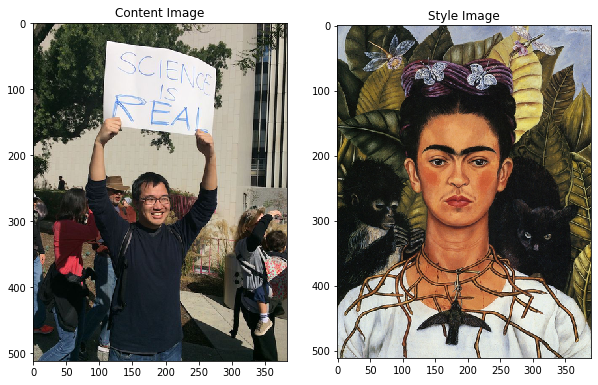

In [5]:
content = load_img(content_file).astype('uint8')
style = load_img(style_file).astype('uint8')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
imshow(content, 'Content Image')
plt.subplot(1,2,2)
imshow(style, 'Style Image')

### Note

In other Neural Transfer applications online, VGG is used (as is in the original Gatys et al. (2015) paper, and the mean is normalized using the BGR channel means:

mean = [103.939, 116.779, 123.68]

Tensorflow seems to have automated this process in the native preprocessing routines.  We also define a routine to undo the mean normalization

In [6]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, axis=0)
        
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    
    if len(x.shape) != 3:
        raise ValueError('Invalid input to deprocess image')
        
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]
    
    x = np.clip(x,0,255).astype('uint8')
    return x
    
    

### Decide which layers of the VGG architechture to pull out style and content images

Here, we're again using the recommended value from Gatys et. al. 

Then, download a pretrained VGG 19 network.  Like most modern deep learning frameworks, Tensorflow/Keras has them pre-saved

In [11]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
    
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    
    # We don't want to update weights, inference only
    vgg.trainable = False   
    
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    return models.Model(vgg.input, model_outputs)

### Loss functions

For content matrix is ye olde squares of differences 



In [8]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [26]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor,[-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a,a,transpose_a = True)
    return gram / tf.cast(n,tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))


In [13]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features



In [14]:
# To be passed in?

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    weights_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weights_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    weights_per_content_layer = 1.0/ float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weights_per_content_layer  * get_content_loss(comb_content[0], target_content)
        
    style_score *= style_weight
    content_score *= content_weight
    
    loss = style_score+content_score
    return loss, style_score, content_score

In [34]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [42]:
import IPython.display 

def run_style_transfer(content_path,
                       style_path,
                       num_iterations = 1000, 
                       content_weight = 1e3,
                       style_weight = 1e-2):
    model = get_model()
    
    # Thought: model is already set untrainable in get_model() so is the following two
    # lines unnecessary?
    for layer in model.layers:
        layer.trainable=False
        
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    initial_image = load_and_process_img(content_path)
    initial_image = tf.Variable(initial_image, dtype=tf.float32)
    optimizer = tf.optimizers.Adam(learning_rate=5, beta_1 = 0.99, epsilon=1e-1)
    
    iter_count = 1
    
    best_loss, best_img = float('inf'), None
    
    loss_weights = [style_weight, content_weight]
    
    cfg = {
        'model': model, 
        'loss_weights': loss_weights,
        'init_image': initial_image, 
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    
    
    # for displays
    num_rows = 2
    num_columns = 5
    display_interval = num_iterations / (num_rows * num_columns)
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    images = []
    for i in range(num_iterations):
        grads, all_losses = compute_grads(cfg)
        loss, style_score, content_score = all_losses
        optimizer.apply_gradients([(grads, initial_image)])
        clipped = tf.clip_by_value(initial_image, min_vals, max_vals)
        initial_image.assign(clipped)
        end_time = time.time()
        
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(initial_image.numpy())
            
        if i % display_interval ==0:
            start_time = time.time()
            
            # Get numpy image values
            plot_image = initial_image.numpy() 
            plot_image = deprocess_img(plot_image)
            images.append(plot_image)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_image))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, ' 
                  'Style loss: {:.4e}, '
                  'Content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time()-start_time))
    print('Total time: {:.4f}s'.format(time.time()-global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(4,4))
    for i,img in enumerate(images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imgshow(img), 
        plt.xticks([])
        plt.yticks([])
        
    return best_img, best_loss
        
        
    

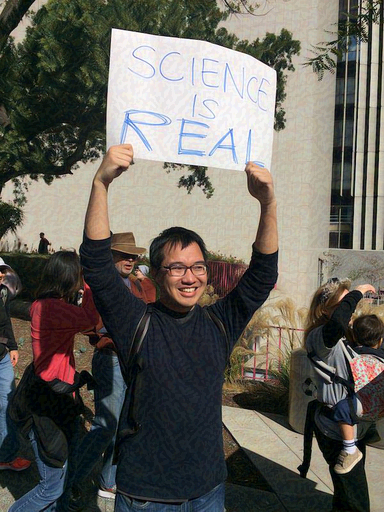

Iteration: 0
Total loss: 8.8701e+07, Style loss: 8.8701e+07, Content loss: 0.0000e+00, time: 0.1011s


KeyboardInterrupt: 

In [43]:
best, best_loss = run_style_transfer(content_file, 
                                     style_file, num_iterations=1000)
